In [10]:
import pandas as pd
import numpy as np
from disaggregator import config, data, spatial, temporal, plot, heat
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 2 Theoretische Grundlagen
## 2.4 Strom- und Wärmenachfrage in Einfamilienhäusern
Zur Lastprognose kleiner Verbraucher ohne registrierende Leistungsmessung wenden Netzbetreiber Standardlastprofile an. Auch im disaggregator wird dieses verwendet. Im Folgenden werden die SLP für EFH berechnet und geplottet.

In [2]:
gas = temporal.disagg_temporal_gas_households_EFH()
power = temporal.CTS_power_slp_generator(state='BE')

disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.temporal: INFO     Working on state: SH.
disaggregator.spatial: INFO     Calculating regional gas demands top-down.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     Working on state: HH.
disaggregator.spatial: INFO     Calculating regional gas demands top-down.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     Working on state: NI.
disaggregator.spatial: INFO     Calculating regional gas demands top-down.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     Working on state: HB.
disaggregator.spatial: INFO     Calculating regional gas demands top-down.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     Working on state: NW.
disaggregator.spatial: INFO     Calculating regional gas demand

Text(0, 0.5, 'Gas')

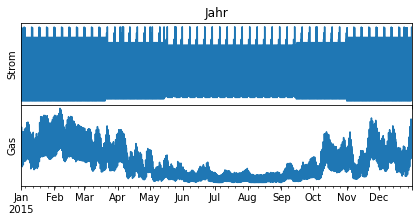

In [3]:
fig, ax = plt.subplots(figsize=(7,3), nrows=2, ncols=1, sharex=True)
power['H0'].plot(ax=ax[0], title='Jahr')
gas.loc[:,['11000_EFH']].plot(ax=ax[1], legend=False)
plt.subplots_adjust(hspace=0)
ax[0].get_yaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[0].set_ylabel('Strom')
ax[1].set_ylabel('Gas')

Text(0, 0.5, 'Gas')

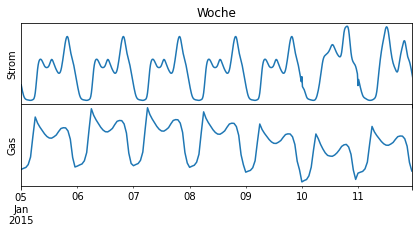

In [4]:
fig, ax = plt.subplots(figsize=(7,3), nrows=2, ncols=1, sharex=True)
power['H0'].iloc[96*4:264*4].plot(ax=ax[0], title='Woche')
gas.loc[:,['11000_EFH']].iloc[96:264].plot(ax=ax[1], legend=False)
plt.subplots_adjust(hspace=0)
ax[0].get_yaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[0].set_ylabel('Strom')
ax[1].set_ylabel('Gas')

## 3 Methode
## 3.1 Stromnachfrage von Wärmepumpen
## 3.1.1 Erstellung von anwendungsspezifsichen Gaszeitreihen
Die Lastprofile für die Raumwärmebereitstellung durch Wärmepumpen aus dem When2Heat Datensatz können von der Website des Projektes Open Power System Data heruntergeladen werden.
https://data.open-power-system-data.org/when2heat/2019-08-06

In [6]:
df = pd.read_csv(config.data_in('heat','when2heat_filtered.csv'), index_col=0)
df.index = pd.to_datetime(df.index)

Text(0, 0.5, 'MW / TWh')

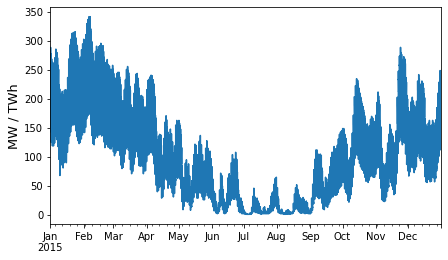

In [7]:
# Normalized heat demand in Germany in MW/TWh for space heating in multi-family houses
df.loc[:,'DE_heat_profile_space_MFH'].plot(xlabel='', figsize=(7,4))
plt.ylabel('MW / TWh', fontsize=13)

## 3.1.2 Temperaturabhängige COP Zeitreihen
Um die Stromnachfrage aus der Wärmenachfrage abzuleiten, werden COP-Zeitreihen in Abhängigkeit der Quelltemperaturen bestimmt. Hierfür werden der Jahresverlauf der Außenluft-, Boden- und Grundwassertemperatur und COP Koeffizienten in Abhängigkeit der Temperaturdifferenz benötigt. 

disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


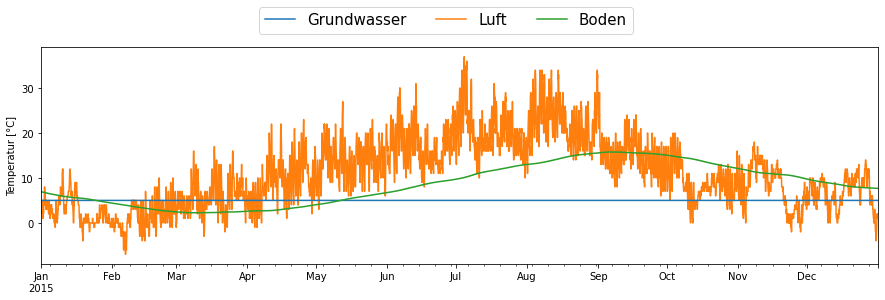

In [2]:
heat.plot_source_temps()

disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


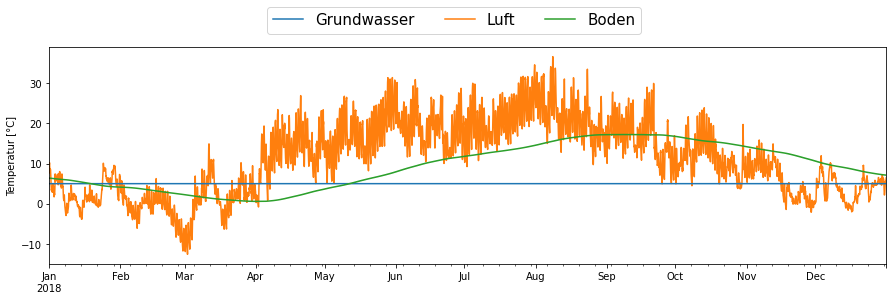

In [7]:
heat.plot_source_temps(year=2018)
plt.savefig('./data_out/temp_2018.png',bbox_inches='tight',dpi=150)

In [66]:
def plot_source_temps(lk=11000, **kwargs):
	"""
	Plots the heat source temperatures of water, air and ground
	Parameters
	----------
	lk : int, default 11000 (Berlin)

	"""

	# get base year
	year = 2018
	
	# change index to datetime
	if ((year % 4 == 0)
			& (year % 100 != 0)
			| (year % 4 == 0)
			& (year % 100 == 0)
			& (year % 400 == 0)):
		periods = 35136
	else:
		periods = 35040
		
	date = pd.date_range((str(year) + '-01-01'), periods= periods/4, freq='H')

	# get source temperatures
	soil_t = heat.soil_temp(year)
	soil_t.index = date

	air_t = data.ambient_T(year=year)
	air_t = heat.change_nuts3_to_ags(air_t)
	air_t.index = date

	water_t = pd.DataFrame(index=soil_t.index, columns=soil_t.columns, data=5)
	lw=0.5
	# plot
	fig, ax = plt.subplots(figsize=(7,2))
	water_t.loc[:,lk].plot(ax=ax, linewidth=lw)
	air_t.loc[:,lk].plot(ax=ax, zorder=1, linewidth=lw)
	soil_t.loc[:,lk].plot(ax=ax, linewidth=lw)
	fig.legend(['Grundwasser','Luft','Boden'],
			  loc = 'lower center',fontsize=10, ncol=3, bbox_to_anchor=(0.5,0.9))
	ax.set_ylabel('Temperatur [°C]')

In [ ]:
plot_source_temps(year=2018)
plt.savefig('./data_out/temp_2018_klein_neu.png',bbox_inches='tight',dpi=150)

disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


In [64]:
def plot_COP():	
	"""
	Plots the COP depending on the temperature difference
	"""
	diff1 = pd.Series(data=range(0,80))
	diff2 = pd.Series(data=range(0,60))

	water_cop = heat.cop_curve(diff2,'water')
	air_cop = heat.cop_curve(diff1,'air')
	ground_cop = heat.cop_curve(diff2,'ground')


	fig, ax = plt.subplots(figsize=(5,2.6))

	lw=0.75
	water_cop.plot(ax=ax, linewidth=lw)
	air_cop.plot(ax=ax, linewidth=lw)
	ground_cop.plot(ax=ax, linewidth=lw)

	fig.legend(['Grundwasser','Luft','Boden'],
			  loc = 'lower center',fontsize=10, ncol=3, bbox_to_anchor=(0.5,0.9))
	ax.set_ylabel('COP')
	ax.set_xlabel('Temperaturdifferenz')
	ax.set_ylim(0,9)

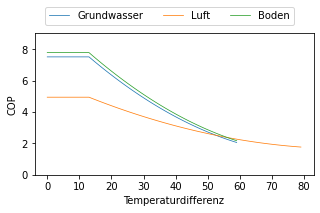

In [65]:
plot_COP()
plt.savefig('./data_out/COP_60_80.png',bbox_inches='tight',dpi=150)

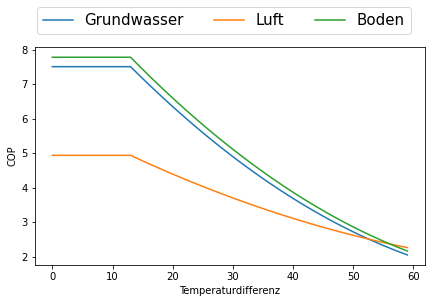

In [3]:
heat.plot_COP()

## 4 Auswertung der Modellergebnisse
## 4.1 Stromnachfrage von Wärmepumpen
## 4.1.1 Erstellung von anwendungsspezifischen Gaszeitreihen
Die Raumwärmenachfrage wird mit Hilfe des SLP-Verahren bestimmt. Dafür wird die Gasnachfrage in Warmwasser/Prozesswärme/Mechanische Energie und Raumwärme geteilt.

disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature indipendent gas temporal disaggregated timeseries.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


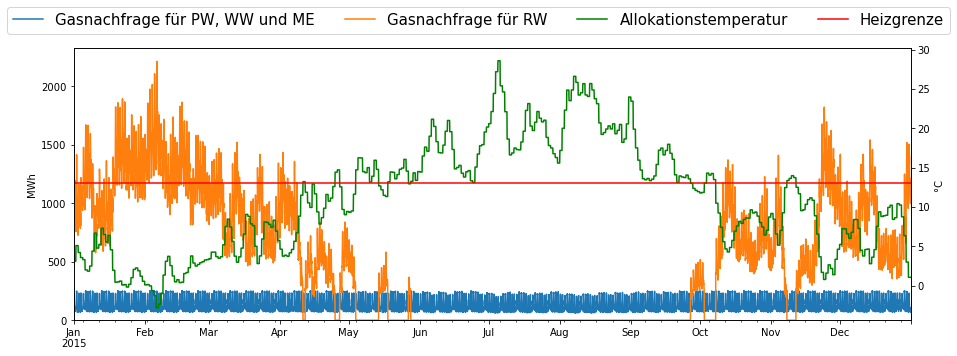

In [2]:
heat_norm, CTS_heat, CTS_tempindi = heat.create_heat_norm(sector='CTS', detailed=False)
CTS_space_unkorrigiert = (CTS_heat-CTS_tempindi).clip(lower=0)
t_allo = heat.resample_t_allo()
CTS_space = CTS_space_unkorrigiert[t_allo[t_allo > 13].isnull()].fillna(0)
heat.plot_gas_demand(CTS_tempindi, CTS_space, t_allo)

Allerdings wird Verfahren von der in Kapitel 3.1.1 abgebildeten Zeitreihen erweitert. Grund dafür ist, dass sonst auch bei Außentemperaturen über der Heizgrenze Raumwärmenachfrage berechnet wird. Das liegt daran, dass der in des Gas-SLPs verwendete h-Wert für RW zwar gegen null geht, jedoch im relevanten Temperaturintervall von -20°C bis 30°C jedoch immer größer als null ist.

In [6]:
# Prozent der Gasnachfrage für RW, in denen Allokationstemperatur über Heizgrenze liegt
round((CTS_space_unkorrigiert[11000].sum()-CTS_space[11000].sum())*100/CTS_space_unkorrigiert[11000].sum(),2)

7.79

In [11]:
# Anzahl der Zeitschritte mit Gasnachfrage für RW, obwohl Allokationstemperatur über Heizgrenze liegt
CTS_space[11000].loc[CTS_space[11000]==0].size

3672

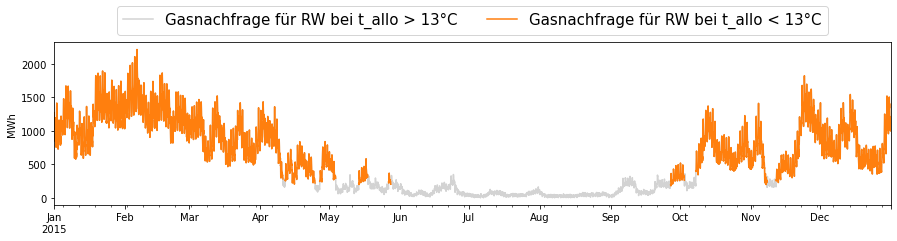

In [3]:
fig, ax = plt.subplots(figsize =(15,3))
CTS_space_unkorrigiert.loc[:,11000].plot(ax=ax, color='lightgrey')
CTS_space_unkorrigiert[t_allo[t_allo > 13].isnull()].loc[:,11000].plot(ax=ax, color='tab:orange')
plt.legend(['Gasnachfrage für RW bei t_allo > 13°C','Gasnachfrage für RW bei t_allo < 13°C'],
           loc = 'lower center',fontsize=15, ncol=2, bbox_to_anchor=(0.5,1))
plt.ylabel('MWh')
plt.show()

In [3]:
params = config.gas_load_profile_parameters_dict()

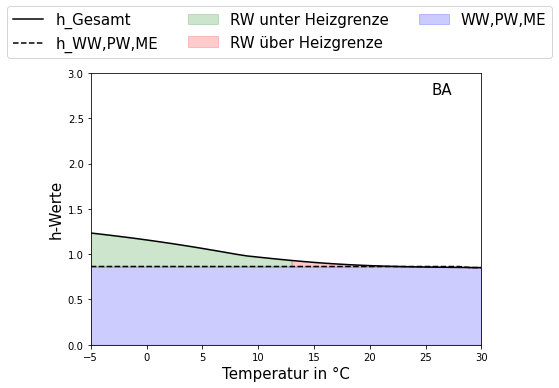

In [4]:
slp = 'BA'
lin_df = pd.DataFrame(data=range(-5,31), columns=['Temperatur'])
lin_df['Warmwasser'] = params['mW'][slp]*lin_df['Temperatur']+params['bW'][slp]
lin_df['Raumwärme'] = params['mH'][slp]*lin_df['Temperatur']+params['bH'][slp]
lin_df['Sigmoid'] = params['A'][slp] / (1 + pow(params['B'][slp] / (lin_df['Temperatur'] - 40), params['C'][slp])) + params['D'][slp]
lin_df['Gesamt'] = lin_df['Sigmoid']+lin_df[['Warmwasser','Raumwärme']].max(axis=1)
lin_df.loc[0:33,'Warmwasser/Prozesswärme/mechanische Energie'] = params['D'][slp]+params['mW'][slp]*13+params['bW'][slp]
lin_df.loc[34:,'Warmwasser/Prozesswärme/mechanische Energie'] = params['D'][slp]+params['mW'][slp]*lin_df['Temperatur']+params['bW'][slp]
lin_df.set_index('Temperatur', inplace=True)

fig, ax = plt.subplots(figsize=(7,5))
lin_df['Gesamt'].plot(ax=ax, color='black', label='h_Gesamt')
lin_df['Warmwasser/Prozesswärme/mechanische Energie'].plot(ax=ax, linestyle='--', color='black',
                                                          label='h_WW,PW,ME')
plt.fill_between(x=lin_df.loc[-21:13].index, y1=lin_df.loc[-21:13,'Warmwasser/Prozesswärme/mechanische Energie'], 
                 y2=lin_df.loc[-21:13,'Gesamt'], alpha=0.2, 
                 label='RW unter Heizgrenze', color='g')
plt.fill_between(x=lin_df.loc[13:].index, y1=lin_df.loc[13:,'Warmwasser/Prozesswärme/mechanische Energie'], 
                 y2=lin_df.loc[13:,'Gesamt'], alpha=0.2, 
                 label='RW über Heizgrenze', color='r')
plt.fill_between(x=lin_df.index, y1=lin_df.loc[:,'Warmwasser/Prozesswärme/mechanische Energie'], 
                 alpha=0.2, label='WW,PW,ME', color='b')
plt.title(slp,x=0.9, y=0.9, fontsize=15)
plt.ylim(0,3)
plt.xlim(-5,30)
ax.set_ylabel('h-Werte', fontsize=15)
ax.set_xlabel('Temperatur in °C', fontsize=15)
fig.legend(loc = 'lower center',fontsize=15, ncol=3, bbox_to_anchor=(0.5,0.9))

## 4.1.2 Stromnachfragezeitreihen nach Wärmequelle und Fortschreibung
Die Stromnachfragezeitreihen als Produkt der RW-Nachfrage- und der COP-Zeitreihen hängen von den Gas-SLP und den temperaturabhängigen COP ab. Zur Verdeutlichung dieser Abhängigkeiten, sind im Flgenden der normierte Stromverbrauch von den drei verschiedenen Wärmepumpentypen im Haushaltssektor dargestellt.

In [4]:
ec_heat_ground = heat.RW_ec(sector = 'HH', p_ground=1, p_air=0, p_water=0)
ec_heat_air = heat.RW_ec(sector = 'HH', p_ground=0, p_air=1, p_water=0)
ec_heat_water = heat.RW_ec(sector = 'HH', p_ground=0, p_air=0, p_water=1)

disaggregator.heat: INFO     Creating heat norm timeseries.
disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature indipendent gas temporal disaggregated timeseries.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.heat: INFO     Creating heat norm timeseries.
disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature indipendent gas temporal disaggregated timeseries.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.heat: INFO     Creating heat norm timeseries.
disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature indipendent gas tempora

disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


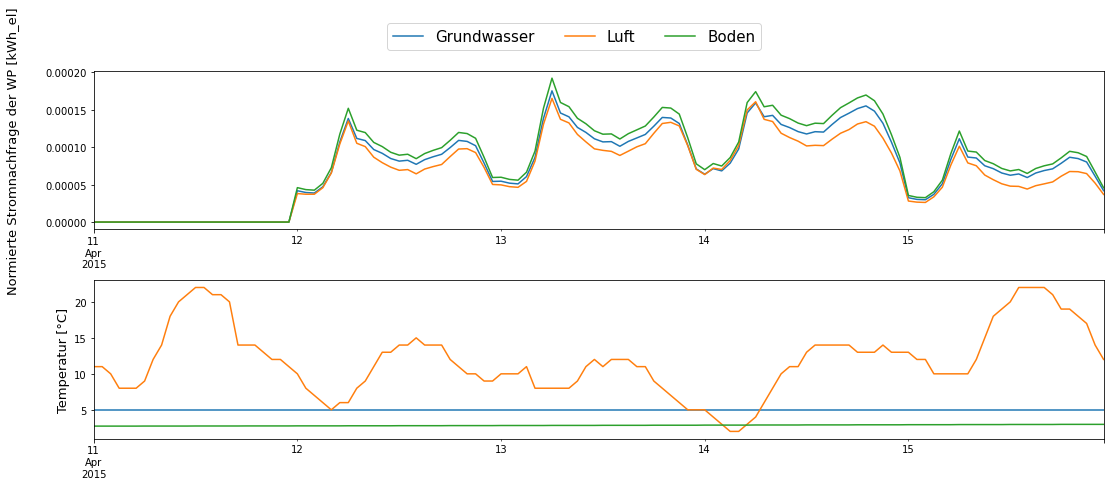

In [5]:
heat.plot_heat_pump_source(ec_heat_ground/ec_heat_ground.sum(), 
                           ec_heat_air/ec_heat_air.sum(),
                           ec_heat_water/ec_heat_water.sum(), 
                           start=100, end=105)

disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


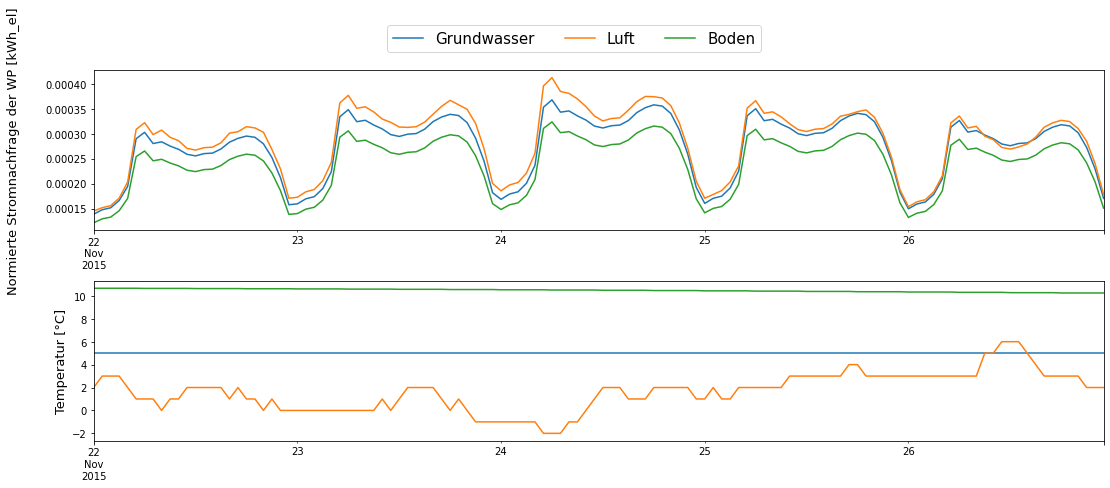

In [6]:
heat.plot_heat_pump_source(ec_heat_ground/ec_heat_ground.sum(), 
                           ec_heat_air/ec_heat_air.sum(),
                           ec_heat_water/ec_heat_water.sum(), 
                           start=325, end=330)

Für die Fortschreibung im Jahr 2030 muss für HH und GHD im Funktionsaufruf der Stromverbrauch für RW in TWh angegeben werden.

disaggregator.heat: INFO     Creating heat norm timeseries.
disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature indipendent gas temporal disaggregated timeseries.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
For the specified year no application disaggregation keys were found, using the base year 2015. Try adjusting the file in 'data_in/dimensionless'.
disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/demandregio_spatial?id_spatial=eq.71&&year=eq.2030&&value=gt.0.0
disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/demandregio_spatial?id_spatial=eq.71&&year=eq.2029&&value=gt.0.0
disaggregator.config: INFO     Querying from:
http://opendata.ffe.de:4000/demandregio_spatial?id_spatial=eq.71&&year=eq.2028&&value=gt.0.0
disaggregator.config: INFO     Querying from:
http:/

(0.0, 8000.0)

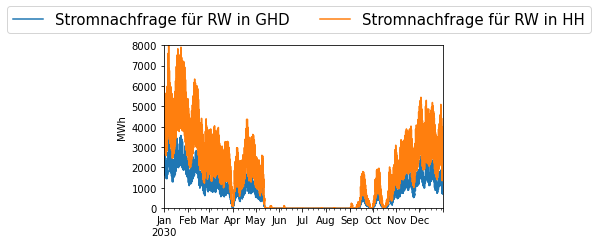

In [7]:
ec_heat_CTS = heat.RW_ec(sector='CTS', detailed=False, RW_scenario=6.26)
ec_heat_HH = heat.RW_ec(sector='HH', detailed=False, RW_scenario=15.43)

fig, ax = plt.subplots(figsize=(5,3))
ec_heat_CTS.sum(axis=1).plot(ax=ax)
ec_heat_HH.sum(axis=1).plot(ax=ax)

fig.legend(['Stromnachfrage für RW in GHD','Stromnachfrage für RW in HH'],
          loc = 'lower center',fontsize=15, ncol=2, bbox_to_anchor=(0.5,0.9))
ax.set_ylabel('MWh')
plt.ylim(0,8000)

## 4.1.3 Erreichte Jahresarbeitszahlen
Um die Plausibilität der verwendeten COP zu prüfen, werden die JAZ mit errechnet und verglichen.

In [12]:
air_floor_cop, ground_floor_cop, water_floor_cop = heat.cop_ts()

disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


In [15]:
# Luft-Wärmepumpe
(air_floor_cop.loc[:,11000]*ec_heat_air.loc[:,11000]).sum()/ec_heat_air.loc[:,11000].sum()

3.3736295726565535

In [16]:
# Sole-Wärmepumpe
(ground_floor_cop.loc[:,11000]*ec_heat_ground.loc[:,11000]).sum()/ec_heat_ground.loc[:,11000].sum()

3.98462678120101

In [17]:
# Grundwasser-Wärmepumpe
(water_floor_cop.loc[:,11000]*ec_heat_water.loc[:,11000]).sum()/ec_heat_water.loc[:,11000].sum()

4.268099784851074

## 4.2 Speichernutzung in Prosumer Einfamilienhäusern
## 4.2.1 Größen der Systemkomponenten
Der jährliche Stromverbrauch der WP, der jährliche Stromverbrauch für herkömmlichen Haushaltsstrom und die installierten PV-Leistung werden zu Skalierung der Zeitreihen verwendet.

In [12]:
results_dict = heat.prosumer_ts(jvlh=802, # Jahresvollaststunden der PV Anlage
                           PV_peak = 6.6, # installierte PV Leistung
                           Wohnfläche = 147.4, # Wohnfläche des Haushalts
                           sv = 4200, # Jahresstromverbrauch des Haushalts
                           s_vol = 590, # Volumen des Pufferspeichers
                           b_max=4.2, # Kapazität des Batteriespeichers
                           state='BE', # Bundesland
                           JAZ=3.7) # Jahresarbeitszahl der Wärmepumpe

disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature independent gas temporal disaggregated timeseries.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


In [60]:
results_dict[11000].columns

Index(['PV-Ertrag', 'COP', 'HH Netzbezug mit Speicher',
       'HH Netzbezug ohne Speicher', 'Stand Batteriespeicher',
       'WP Netzbezug mit Speicher', 'WP Netzbezug ohne Speicher',
       'Stand Pufferspeicher', 'PV Netzeinspeisung'],
      dtype='object')

In [61]:
# Stromverbrauch der WP
results_dict[11000]['WP Netzbezug ohne Speicher'].sum()

2390.27027027027

In [62]:
# maximale Wärmeleistung der WP
WP_max = results_dict[11000]['WP Netzbezug ohne Speicher'].max()*results_dict[11000]['COP'][results_dict[11000]['WP Netzbezug ohne Speicher'].idxmax()]*4
print (WP_max)

5.879184363997425


In [63]:
# maximale Wärmemenge des Pufferspeichers
(WP_max*100*1.163*(40-35))/1000

3.4187457076645025

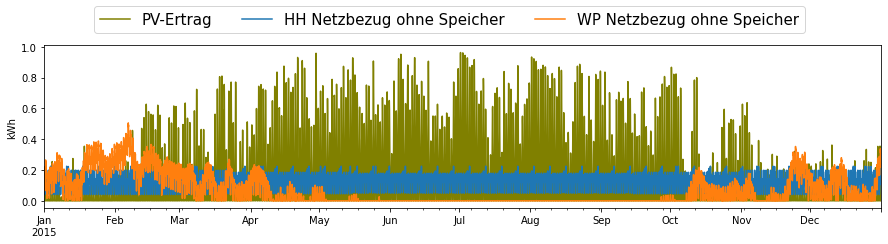

In [11]:
heat.plot_prosumer(results_dict, columns=['PV-Ertrag','HH Netzbezug ohne Speicher','WP Netzbezug ohne Speicher'])

## 4.2.2 Resultierende Zeitreihen der Speichernutzung
Auf der linke Achse der folgenden Abbildungen ist der Netzbezug für WP oder herkömmlichen Haushaltsstrom sowie PV-Ertrag und -Netzeinspeisung dargestellt. Die rechte Achse zeigt den Speicherstand des Puffer- oder Batteriespeichers. Nach der Reduktion der Stromnetznachfage eines einzelnen Haushaltes wird der Einfluss aller Prosumer Haushalte eines Landkreises betrachtet. 

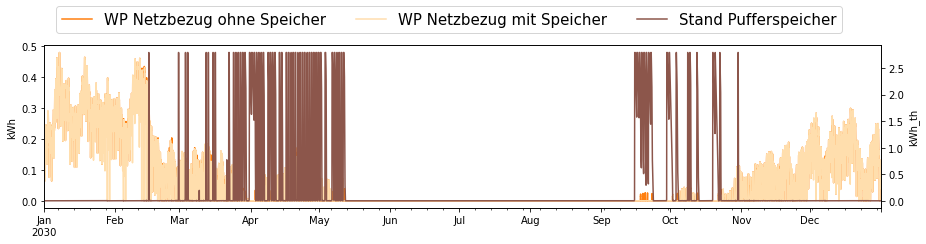

In [5]:
heat.plot_prosumer(results_dict, columns=['WP Netzbezug ohne Speicher','WP Netzbezug mit Speicher','Stand Pufferspeicher'])

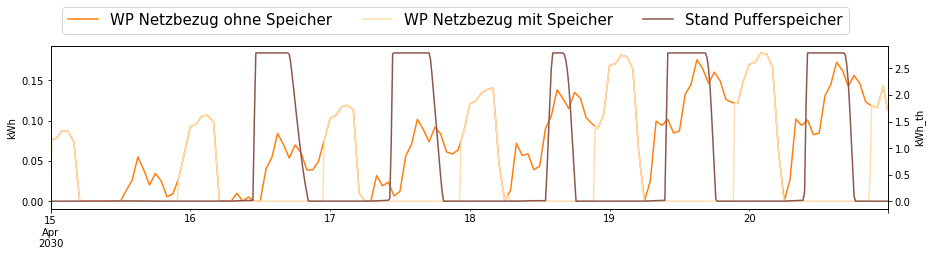

In [6]:
heat.plot_prosumer(results_dict, columns=['WP Netzbezug ohne Speicher','WP Netzbezug mit Speicher','Stand Pufferspeicher'],
                  start=104, end=110)

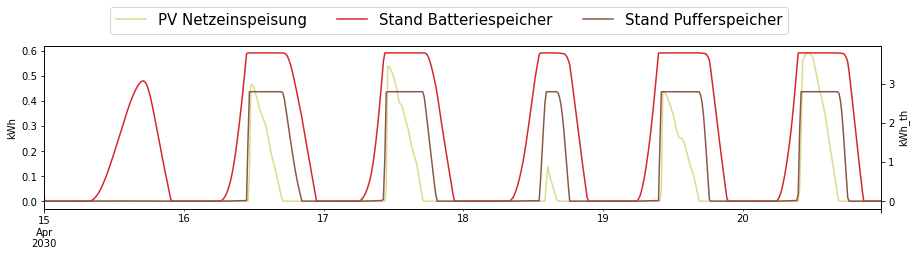

In [7]:
heat.plot_prosumer(results_dict, columns=['PV Netzeinspeisung','Stand Batteriespeicher','Stand Pufferspeicher'],
                  start=104, end=110)

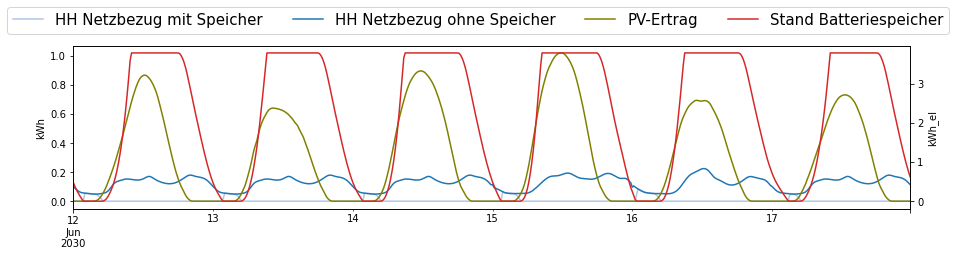

In [8]:
heat.plot_prosumer(results_dict, columns=['HH Netzbezug mit Speicher','HH Netzbezug ohne Speicher','PV-Ertrag','Stand Batteriespeicher'],
                  start=162, end=168)

In [25]:
# Anzahl an Prosumer Haushalten je Bundesland
total=2140000
# read excel file with predefined household charateristics
path = config.data_in('heat','Prosumer_HH.xlsx')
BL_spez = pd.read_excel(path, index_col=0, header=0, sheet_name='BL')

# calculate number of prosumer hh in given state
number_prosumer = (BL_spez['Anzahl der Solarstromspeicher']/
                BL_spez['Anzahl der Solarstromspeicher'].sum())*total
number_prosumer.astype(int)

SH     46448
HH      9213
NI    223624
HB      4501
NW    362517
HE    132890
RP     95654
BW    336833
BY    772322
SL     24812
BE      9422
BB     44075
MV     11969
SN     23102
ST     23765
TH     18844
Name: Anzahl der Solarstromspeicher, dtype: int32

In [2]:
WP_Netz, HH_Netz, PV_Ertrag, PV_Netz = heat.prosumer_hh_bl(state='BE', total=2140000, hh_size=[4])

cmap = plt.cm.get_cmap('tab20')
color_dict = {'PV-Ertrag':'olive', 'COP':cmap(9/21), 'HH Netzbezug mit Speicher':cmap(2/21), #cmap(17/21)
			  'HH Netzbezug ohne Speicher':cmap(1/21),'Stand Batteriespeicher':cmap(7/21), 
			  'WP Netzbezug mit Speicher':'navajowhite','WP Netzbezug ohne Speicher':'tab:orange',#cmap(4/21),cmap(3/21), 
			  'Stand Pufferspeicher':cmap(11/21), 'PV Netzeinspeisung':cmap(18/21)}

disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature independent gas temporal disaggregated timeseries.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


In [3]:
# Reduktion der Stromnetznachfrage für Deckung der herkömmlichen Haushaltsstrom
int(WP_Netz.sum())/1000

-2610.654

In [4]:
# Reduktion der Stromnetznachrage für WP
int(HH_Netz.sum())/1000

-25880.812

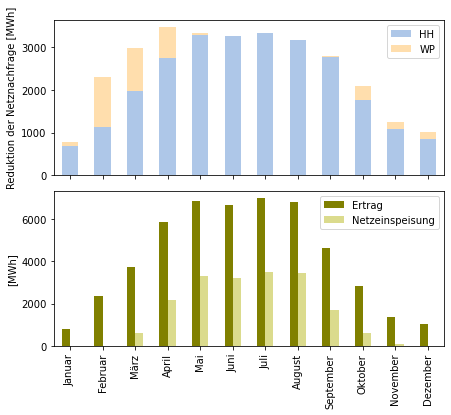

In [8]:
Strom = pd.concat([HH_Netz.resample('M').sum()*(-0.001),WP_Netz.resample('M').sum()*(-0.001)], axis=1)
Strom.columns = ['HH','WP']

PV = pd.concat([PV_Ertrag.resample('M').sum()*(0.001),PV_Netz.resample('M').sum()*(0.001)], axis=1)
PV.columns = ['Ertrag','Netzeinspeisung']

fig, ax = plt.subplots(figsize=(7,6), nrows=2, sharex=True)
Strom.plot(kind='bar', ax=ax[0], stacked=True, color=[color_dict['HH Netzbezug mit Speicher'],
                                                   color_dict['WP Netzbezug mit Speicher']])

PV.plot(kind='bar', ax=ax[1], color=[color_dict['PV-Ertrag'],
                                  color_dict['PV Netzeinspeisung']])

ax[1].set_xticklabels(['Januar','Februar','März','April','Mai','Juni','Juli','August','September','Oktober','November','Dezember'])
ax[0].set_ylabel('Reduktion der Netznachfrage [MWh]')
ax[1].set_ylabel('[MWh]')
plt.subplots_adjust(hspace=0.1)
plt.show()

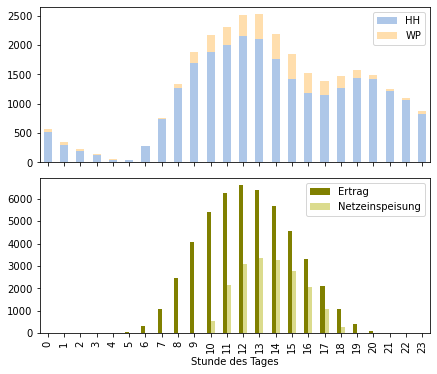

In [11]:
Strom = pd.concat([HH_Netz.groupby(by=HH_Netz.index.hour).sum()*-0.001,
                   WP_Netz.groupby(by=WP_Netz.index.hour).sum()*-0.001], axis=1)
Strom.columns = ['HH','WP']

PV = pd.concat([PV_Ertrag.groupby(by=PV_Ertrag.index.hour).sum()*0.001,
                PV_Netz.groupby(by=PV_Netz.index.hour).sum()*0.001], axis=1)
PV.columns = ['Ertrag','Netzeinspeisung']

fig, ax = plt.subplots(figsize=(7,6), nrows=2, sharex=True)
Strom.plot(kind='bar', stacked=True, ax=ax[0], color=[color_dict['HH Netzbezug mit Speicher'],
                                                   color_dict['WP Netzbezug mit Speicher']])
PV.plot(kind='bar', ax=ax[1], color=[color_dict['PV-Ertrag'],
                                  color_dict['PV Netzeinspeisung']])
plt.xlabel('Stunde des Tages')
#ax[0].set_ylabel('Reduktion der Netznachfrage [MWh]')
#ax[1].set_ylabel('[MWh]')
plt.subplots_adjust(hspace=0.1)
plt.show()

## 4.2.3 Vergleich der Eigenverbrauchsquote und des Autarkiegrades
Als Bewertungskriterien des Verbrauchs von PV-Strom durch Prosumer werden die Eigenverbrauchsquote und der Autarkiegrad berechnet. 

In [40]:
results_dict = heat.prosumer_ts(jvlh=802, # Jahresvollaststunden der PV Anlage
                           PV_peak = 6.6, # installierte PV Leistung
                           Wohnfläche = 147.4, # Wohnfläche des Haushalts
                           sv = 4200, # Jahresstromverbrauch des Haushalts
                           s_vol = 590, # Volumen des Pufferspeichers
                           b_max=4.2, # Kapazität des Batteriespeichers
                           state='BE', # Bundesland
                           JAZ=3.7) # Jahresarbeitszahl der Wärmepumpe

disaggregator.heat: INFO     Reading existing total gas temporal disaggregated timeseries.
disaggregator.heat: INFO     Reading existing temperature independent gas temporal disaggregated timeseries.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.
disaggregator.data: INFO     Dropping old NUTS-v2013 regions.


In [41]:
heat.Eigenverbrauchsanteil(results_dict, 11000)

0.5999253519419586

In [42]:
heat.Autarkiegrad(results_dict, 11000)

0.4818504769409006